# Step 4 - Compare the structures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import dill
import pickle
import sys
import tempfile
sys.path.append("scripts/")

from Bio.SeqIO import index as fasta_index, parse
from easyFunctions import *
from InfernalResults import TRACR_RNA, ProcessInfernal
from os import chdir, path, stat, system
from pandas import Series

chdir("data")

if path.exists("pickles/Step4.db"): 
    dill.load_session('pickles/Step4.db')
    print "Loaded Session"

Loaded Session


### Data


In [2]:
infernalResults = ProcessInfernal(2)

Dumping /mnt/research/germs/shane/transActRNA/data/pickles/InfernalResults02.p Number of results: 1119


### For each system, find out how many unique structures where found by checking overlap

In [4]:
condensedResults = {} # {SeqID:[set(tracrLocations)]}
for seqID in infernalResults:
    condensedResults[seqID]=[]
    tracrCoords = set()
    for hit in infernalResults.seqTracrs[seqID].values():
        start = min(hit.location.start,hit.location.end)
        end = max(hit.location.start,hit.location.end)
        coords = set(range(start,end))
        if len(coords.intersection(tracrCoords)) == 0:
            tracrCoords = tracrCoords.union(coords)
            condensedResults[seqID].append(hit)
print len(condensedResults)    

1119


count    1119.000000
mean        2.271671
std         1.502952
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        12.000000
dtype: float64


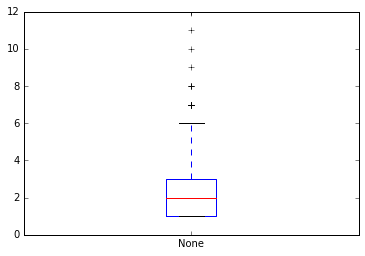

In [5]:
dist = []
for hitList in condensedResults.values(): dist.append(len(hitList))
    
dist = Series(dist)
print dist.describe()
dist.plot.box();

# Which hit is THE hit, and how many sequence cluster structures overlap it?

In [3]:
from collections import Counter
def findBiggestCluster(clusters, clusterMap): return Counter(dict((k, clusterMap[k]) for k in (clusters))).most_common(1)[0][0] 
clusterCounter = {}
for struct,ids in infernalResults.structMapping.iteritems(): clusterCounter[struct] = len(ids)

In [3]:
testCounter = 0
tracrNumDist = []
biggestClusterMap = {} # {"ClusterName:set([SeqID,...])}
SeqClusterMap = {}
combineWsomethingElse=0
for seqID in infernalResults:
    testCounter +=1
#     print "\nSeqID:",seqID
    biggestCluster =  findBiggestCluster(infernalResults[seqID],clusterCounter)
    combo = infernalResults[seqID].intersection(biggestClusterMap.keys())
    if biggestCluster in combo:combo.remove(biggestCluster)
    if biggestCluster not in biggestClusterMap and len(combo) >0:
        biggestCluster =  findBiggestCluster(combo,clusterCounter)
    try: biggestClusterMap[biggestCluster].add(seqID)
    except: biggestClusterMap[biggestCluster] = set([seqID])
    SeqClusterMap[seqID] = biggestCluster
    hitInfo = infernalResults.seqTracrs[seqID][biggestCluster]
#     print "\tMain Tracr:",hitInfo
    overlapCount = 0
    nonOverlapping = {}
    for hit in infernalResults.seqTracrs[seqID].values():
        if hit.structName == hitInfo.structName and hit.location == hitInfo.location: continue
        elif hit.location.overlaps(hitInfo.location):
            #print "\t\tOverlaps:",hit
            overlapCount +=1
        else: nonOverlapping[hit.structName]=hit
#     print "\t\tPrimary Tracr Overlap:",overlapCount
    tracrCounter = 1
    while len(nonOverlapping)> 1:
        tracrCounter+=1
        overlapCount = 0
        biggestCluster = findBiggestCluster(nonOverlapping.keys(),clusterCounter)
        hitInfo = nonOverlapping[biggestCluster]
#         print "\tAlternative tracr %i: %s" % (counter, hitInfo)
        del nonOverlapping[biggestCluster]
        removeList = []
        for hit in nonOverlapping.values(): 
            if hit.location.overlaps(hitInfo.location):
                #print "\t\tOverlaps:",hit
                overlapCount +=1
                removeList.append(hit.structName)
#         print "\t\tAlternative Tracr Overlap:",overlapCount
        for hitName in removeList: del nonOverlapping[hitName]
    if tracrCounter >=10:
        print seqID
    tracrNumDist.append(tracrCounter)
#     if testCounter == 10:break
    

NZ_CP016877.1_ORF2
NZ_CM003138.1_ORF2
NZ_CP019935.1_ORF2


In [4]:
infernalResults_1 = ProcessInfernal(0)

Empty Output File:  Cluster_58.out 0
Empty Output File:  Cluster_89.out 0
Empty Output File:  Cluster_55.out 0
Empty Output File:  Cluster_75.out 0
Empty Output File:  Cluster_125.out 0
Empty Output File:  Cluster_155.out 0
Empty Output File:  Cluster_20.out 0
Empty Output File:  Cluster_142.out 0
Dumping /mnt/research/germs/shane/transActRNA/data/pickles/InfernalResults00.p Number of results: 977


In [11]:
allLoci = pickle.load(open("pickles/TracrLoci.p","rb"))
for seqID in infernalResults:
    if seqID not in allLoci:continue
    seqLocus = allLoci[seqID]
    print seqID
    print "\tStuct Hits:"
    for hit in infernalResults.seqTracrs[seqID].values():
        print "\t\t",hit
    print "\tPossible Tracrs:"
    for coord in seqLocus.possibleTracrs:
        print "\t\t",coord
    print
    

NZ_MNPS01000005.1_ORF3
	Stuct Hits:
		Cluster_1222 [165929	166048]+ 2.5e-08
	Possible Tracrs:
		[166026	166050]+
		[170517	170553]+
		[171310	171346]+

PHEF01000089_ORF1
	Stuct Hits:
		Cluster_1084 [6236	6328]+ 3.2e-07
	Possible Tracrs:
		[6242	6268]+
		[133	169]+
		[1454	1490]+

NZ_LNKK01000004.1_ORF2
	Stuct Hits:
		Cluster_1209 [2181	2283]+ 0.0022
	Possible Tracrs:
		[0	24]+
		[2152	2176]+
		[186	222]+

NVXA01000008_ORF1
	Stuct Hits:
		Cluster_1084 [102984	103076]+ 5.1e-10
	Possible Tracrs:
		[108529	108547]+
		[103048	103069]+
		[107662	107699]+

NZ_BAMU01000030.1_ORF3
	Stuct Hits:
		Cluster_1222 [21152	21294]+ 1.3e-37
	Possible Tracrs:
		[14192	14228]+
		[16635	16671]+
		[21151	21173]+

ONBR01000009_ORF2
	Stuct Hits:
		Cluster_1054 [7853	7961]+ 5.2e-09
	Possible Tracrs:
		[7850	7874]+
		[724	760]+
		[1581	1617]+

DKSH01000019_ORF2
	Stuct Hits:
		Cluster_1054 [2192	2332]+ 6.6e-08
	Possible Tracrs:
		[0	35]+
		[8181	8203]+
		[1910	1946]+

NZ_ANBM01000003.1_ORF3
	Stuct Hits:
		Cluster

In [42]:
from random import randint

r = lambda: randint(0,255)            
def color():return '#%02X%02X%02X' % (r(),r(),r())

In [54]:
import glob
for id in infernalResults_1:
    if id not in SeqClusterMap:continue
    if SeqClusterMap[id] in biggestClusterMap: del biggestClusterMap[SeqClusterMap[id]]

counter, treeColors = {},{}
for id,seqs in biggestClusterMap.iteritems(): 
    counter[id]=len(seqs)
    clusterColor = color()
    for seqID in seqs: treeColors[seqID] = clusterColor
pickle.dump(treeColors,open("pickles/NovelTracrs.p","wb"))
print len(treeColors)
counter = Counter(counter)
for clusterID,count in counter.most_common(100): 
    if count>1:
        print clusterID, count
        chdir("conseqs2/"+clusterID)
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_RNAfold.pl %s.fasta > %s.dbn"
        #system(cmd % (clusterID,clusterID))
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_VARNA_images.pl %s.dbn"
        #system(cmd % (clusterID))
        cmd = "perl /mnt/research/germs/shane/transActRNA/scripts/varna/HTP_VARNA_images.pl %s.bt"
        system(cmd % (clusterID))
        jpgs = glob.glob("*.jpg")
        for pic in jpgs:
            system("cp %s /mnt/research/germs/shane/transActRNA/data/images/novel/%s" % (pic,clusterID+pic))
        chdir("../../")

77
Cluster_166 15
Cluster_1084 13
Cluster_706 7
Cluster_1222 6
Cluster_457 4
Cluster_1461 4
Cluster_1729 3
Cluster_1584 3
Cluster_909 3
Cluster_581 2
Cluster_1054 2
Cluster_401 2
Cluster_282 2
Cluster_1441 2
Cluster_1553 2


In [8]:
tracrNumDist = Series(tracrNumDist)

In [49]:
%%bash
pwd


/mnt/research/germs/shane/transActRNA/data/conseqs0/Cluster_166


count    1119.000000
mean        1.923146
std         1.314359
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        12.000000
dtype: float64


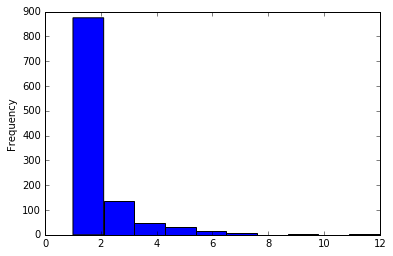

In [9]:
print tracrNumDist.describe()
tracrNumDist.plot.hist();

# Generate Images of each cluster

#### Fold the tracrRNAs and generate an image

In [ ]:
chdir("conseqs2")
newTracrPath = ""
files = os.listdir("./")
for dirname in files:
    chdir(dirname)
    os.system("perl RNACompare/HTP_RNAfold.pl %s >%s.dbn" %(kozak_path+filename,kozak_path+filename))
    os.system("perl RNACompare/HTP_VARNA_images.pl %s > cmd" % filename)
    chdir("..")

In [3]:
%%bash
pwd
ls

/mnt/research/germs/shane/transActRNA/data
AbundanceData.txt
alignments
annotations
assemblies
blastDBs
blastout
clusters
conseqs0
conseqs1
conseqs2
conseqs3
crisprs
diverseCas9s
domains
hmmSearch
images
logs
old
pickles
proteins
sequences
SoilManureContigAbundanceCounts.tsv
tmp
trees


In [4]:
from optparse import OptionParser
from os import system
from Bio.SeqIO import parse

parser = OptionParser()

In [ ]:
parser.add_option(re)

# Save the session

In [10]:
dill.dump_session('pickles/Step4.db')

### For each putative tracrRNA, compare to see if there is overlap between the consensus blast results

In [5]:
condensedResults

{'NZ_NDGA01000017.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c65a8>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6638>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c66c8>],
 'NZ_GL379772.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6758>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c67e8>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6878>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6908>],
 'NZ_KE150494.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6998>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6a28>,
  <InfernalResults.TRACR_RNA instance at 0x2b8b833c6ab8>],
 'NZ_AZFB01000003.1_ORF2': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6b48>],
 'NZ_AZDX01000018.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6bd8>],
 'MEEU01000082_ORF3': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6cb0>],
 'NZ_ALSD01000016.1_ORF1': [<InfernalResults.TRACR_RNA instance at 0x2b8b833c6d88>,
  <InfernalRe

### Figure out the direction of the tracrRNA 

In [ ]:
os.chdir(kozak_path)
files = os.listdir("./")
for filename in files:
    if ".dbn" not in filename:continue
    #os.system("perl RNACompare/HTP_VARNA_images.pl %s > cmd" % filename)

In [ ]:
os.chdir("../RNACompare")

In [ ]:
%%bash
pwd
#ls -alh Kozak/
#rm Kozak/*.fa Kozak/*.dbn

In [ ]:
# for rec in parse("Random_200.txt_out.txt","fasta"):
#     fh = open("kozaks/%s.fa" % (rec.id),"w")
#     fh.write(">%s\n%s\n" % (rec.id,str(rec.seq)))
#     fh.close()    

In [ ]:
files = os.listdir("kozaks/")
for filename in files:
    if ".gb" in filename:continue
    #os.system("perl RNACompare/HTP_RNAfold.pl kozaks/%s >kozaks/%s.dbn" %(filename,filename))

In [ ]:
files = os.listdir("kozaks/")
for filename in files:
    if ".dbn" not in filename:continue
    #print "perl HTP_VARNA_images.pl kozaks/%s > VARNA_cmdline.txt" % (filename)
    #os.system("perl HTP_VARNA_images.pl kozaks/%s > VARNA_cmdline.txt" % (filename))